In [2]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib ipympl

import sys 
import os
from os import path as pt
import numpy as np
import matplotlib.pyplot as plt
import ot
from tqdm import tqdm
import random
import time
import warnings

# Define paths
notebooks_path = os.path.abspath(os.getcwd()) 
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import modules
from multi_dimension.Multidimension_trees import *
from multi_dimension.Multidimension_solver import *
from multi_dimension.Multidimension_adapted_empirical_measure import *

from measure_sampling.Gen_Path_and_AdaptedTrees import generate_adapted_tree
from trees.Tree_Node import *
from trees.TreeAnalysis import *
from trees.TreeVisualization import *
from trees.Save_Load_trees import *
from trees.Tree_AWD_utilities import *
from trees.Build_trees_from_paths import build_tree_from_paths

from adapted_empirical_measure.AEM_grid import *
from adapted_empirical_measure.AEM_kMeans import *
from benchmark_value_gaussian.Comp_AWD2_Gaussian import *
from awd_trees.Gurobi_AOT import *
from awd_trees.Nested_Dist_Algo import compute_nested_distance, compute_nested_distance_parallel, compute_nested_distance_parallel_generic

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Import custom modules from src
from utils_solver import Lmatrix2paths, adapted_empirical_measure, adapted_wasserstein_squared, quantization, nested, plot_V

np.random.seed(0)
random.seed(0)
verbose = True

2025-03-19 19:37:24,101	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-19 19:37:24,176	INFO packaging.py:575 -- Creating a file package for local module '/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/src'.
2025-03-19 19:37:24,224	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_8196e246f1f5ed92.zip' (0.52MiB) to Ray cluster...
2025-03-19 19:37:24,230	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_8196e246f1f5ed92.zip'.
2025-03-19 19:37:28,973	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-19 19:37:29,011	INFO packaging.py:575 -- Creating a file package for local module '/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/src'.
2025-03-19 19:37:29,056	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_8196e246f1f5ed92.zip' (0.52MiB) to Ray cluster...
2025-03-19 19:37:29,063	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_8196e246f1f5ed92.zip'.


# Markovian Gaussian Process

mu
Cholesky:
[[1 0 0]
 [1 2 0]
 [2 4 2]]
Covariance:
[[ 1  1  2]
 [ 1  5 10]
 [ 2 10 24]]
nu
Cholesky:
[[1 0 0]
 [2 1 0]
 [2 1 2]]
Covariance:
[[1 2 2]
 [2 5 5]
 [2 5 9]]


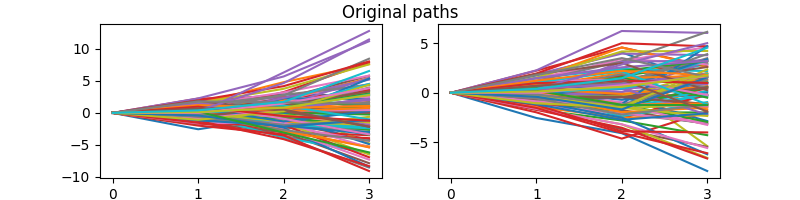

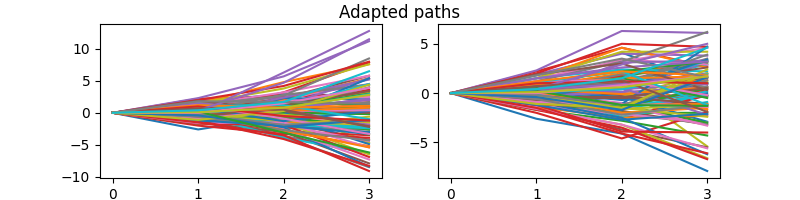

In [2]:
# Markovian
n_sample = 1000
normalize = False

print("mu")
L = np.array([[1, 0, 0], [1, 2, 0], [2, 4, 2]])
X,A = Lmatrix2paths(L, n_sample, seed = 0)

print("nu")
M = np.array([[1, 0, 0], [2, 1, 0], [2, 1, 2]])
Y,B = Lmatrix2paths(M, n_sample, seed = 0)

if verbose:
    fig, ax = plt.subplots(1, 2, figsize=[8, 2])
    ax[0].plot(X[:,:100])
    ax[1].plot(Y[:,:100])
    plt.suptitle('Original paths')
    plt.show()

# Grid projection of k-mean projection
adaptedX = adapted_empirical_measure(X, delta_n = 0.1)
adaptedY = adapted_empirical_measure(Y, delta_n = 0.1)

if verbose:
    fig, ax = plt.subplots(1,2, figsize=[8, 2])
    ax[0].plot(adaptedX[:,:100])
    ax[1].plot(adaptedY[:,:100])
    plt.suptitle('Adapted paths')
    plt.show()

# Markovian Nested Solver

In [3]:
q2v, v2q, mu_x, nu_y, q2v_x, v2q_x, q2v_y, v2q_y = quantization(adaptedX, adaptedY, markovian=True)
AW_2square, V = nested(mu_x, nu_y, v2q_x, v2q_y, q2v, markovian=True)
dist_bench = adapted_wasserstein_squared(A, B)
print("Theoretical AW_2^2: ", dist_bench)
print("Numerical AW_2^2: ", AW_2square)

Quantization ......
Number of distinct values in global quantization:  211
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 57
Time 2: 110
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 57
Time 2: 116
Nested backward induction .......


Timestep 0: 100%|██████████| 1/1 [00:00<00:00, 298.36it/s]

Theoretical AW_2^2:  11.0
Numerical AW_2^2:  10.910538174273363


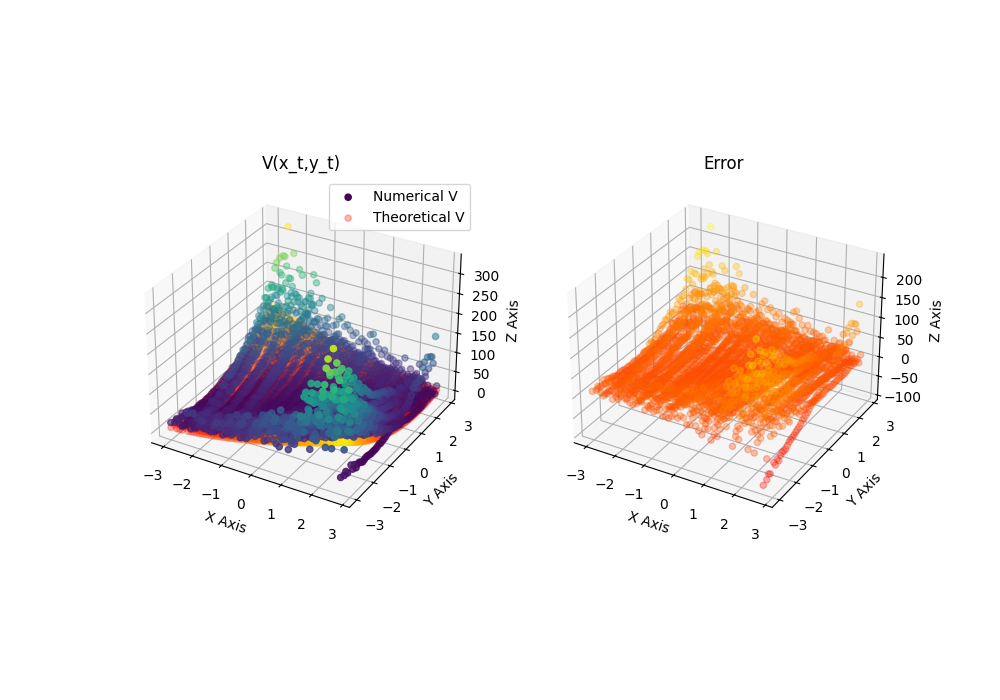

In [4]:
fig, ax = plot_V(q2v, q2v_x, q2v_y, V, t = 1, markovian=True, L = L, M = M)


# Non-Markovian Nested Solver

In [5]:
q2v, v2q, mu_x, nu_y, q2v_x, v2q_x, q2v_y, v2q_y = quantization(adaptedX, adaptedY, markovian=False)
AW_2square, V = nested(mu_x, nu_y, v2q_x, v2q_y, q2v, markovian=False)
dist_bench = adapted_wasserstein_squared(A, B)
print("Theoretical AW_2^2: ", dist_bench)
print("Numerical AW_2^2: ", AW_2square)

Quantization ......
Number of distinct values in global quantization:  211
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 57
Time 2: 820
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 57
Time 2: 692
Nested backward induction .......


Timestep 0: 100%|██████████| 1/1 [00:00<00:00, 372.99it/s]

Theoretical AW_2^2:  11.0
Numerical AW_2^2:  10.222063592415157


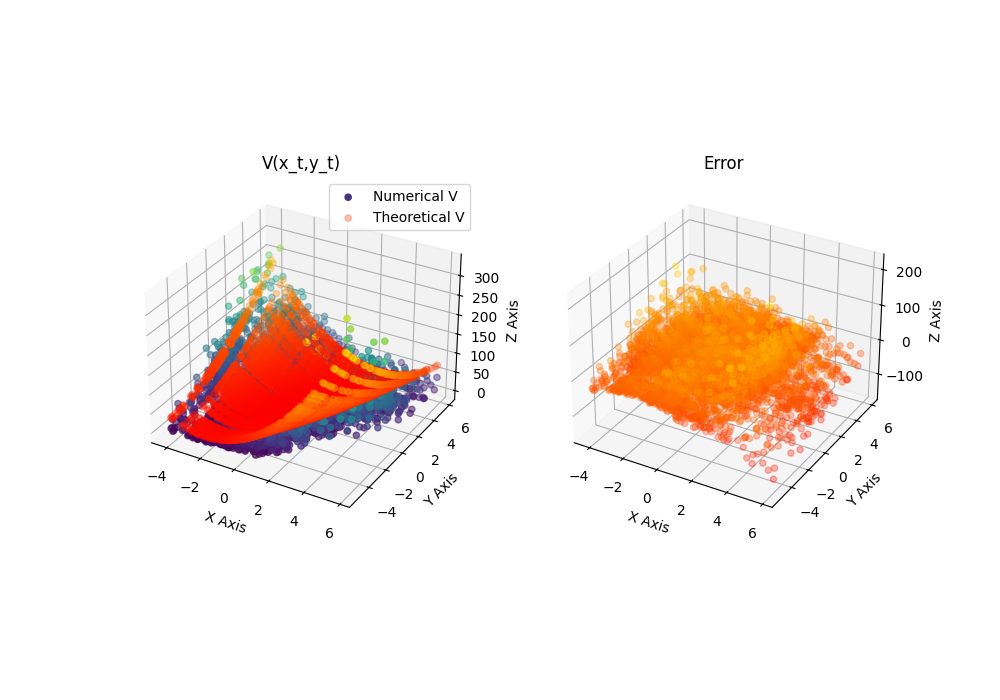

In [6]:
fig, ax = plot_V(q2v, q2v_x, q2v_y, V, t = 2, markovian=False, L = L, M = M)

## Computation with optimized code:

In [3]:
# Markovian
n_sample = 10000
normalize = False

print("mu")
L = np.array([[1, 0, 0], [1, 2, 0], [2, 4, 2]])
X,A = Lmatrix2paths(L, n_sample, seed = 0)

print("nu")
M = np.array([[1, 0, 0], [2, 1, 0], [2, 1, 2]])
Y,B = Lmatrix2paths(M, n_sample, seed = 0)

# Grid projection of k-mean projection
adaptedX = adapted_empirical_measure(X, delta_n = 0.05)
adaptedY = adapted_empirical_measure(Y, delta_n = 0.05)

q2v, v2q, mu_x, nu_y, q2v_x, v2q_x, q2v_y, v2q_y = quantization(adaptedX, adaptedY, markovian=True)

mu
Cholesky:
[[1 0 0]
 [1 2 0]
 [2 4 2]]
Covariance:
[[ 1  1  2]
 [ 1  5 10]
 [ 2 10 24]]
nu
Cholesky:
[[1 0 0]
 [2 1 0]
 [2 1 2]]
Covariance:
[[1 2 2]
 [2 5 5]
 [2 5 9]]
Quantization ......
Number of distinct values in global quantization:  568
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 132
Time 2: 287
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 132
Time 2: 274


In [5]:
AW_2square_par = compute_nested_distance_parallel_generic(mu_x, nu_y, v2q_x, v2q_y, q2v, markovian=True, num_chunks=12)
print("Numerical parallel AW_2^2: ", AW_2square_par)

Parallel nested backward induction ...
Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Numerical parallel AW_2^2:  11.137899739575053


In [6]:
AW_2square, V = nested(mu_x, nu_y, v2q_x, v2q_y, q2v, markovian=True)
print("Numerical AW_2^2: ", AW_2square)

Nested backward induction .......


Timestep 0: 100%|██████████| 1/1 [00:00<00:00, 214.05it/s]

Numerical AW_2^2:  11.137899739575053


In [8]:
dist_bench = adapted_wasserstein_squared(A, B)
print("Theoretical AW_2^2: ", dist_bench)
print("Numerical AW_2^2: ", AW_2square)
print("Numerical parallel AW_2^2: ", AW_2square_par)

Theoretical AW_2^2:  11.0
Numerical AW_2^2:  11.137899739575053
Numerical parallel AW_2^2:  11.137899739575053
